In [9]:
#========================
# Libraries
#========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go
import plotly.express as px
import pickle # To save the model
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
#==============================
# Loading the dataset
#==============================
# The directory of the project
basedir = "C:/Users/ilung/Documents/Jedha_bootcamp/capstone_project"

# Loading the dataset
dataset = pd.read_excel(f"{basedir}/data/clean/france/2022.xlsx")

# Standardizing the pollutants concentration
pollutants = dataset[["no2", "o3", "pm2p5", "pm10", "so2"]]
scaler = StandardScaler()
pollutants_scaled = scaler.fit_transform(pollutants)

Text(0, 0.5, 'Distance to the nearest neighbor')

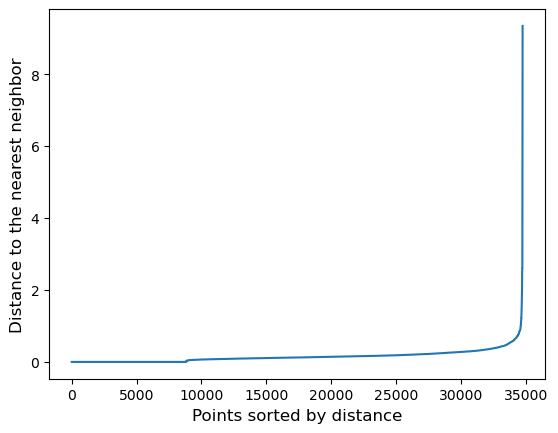

In [3]:
#================================================
# Finding the optimal value of eps
#================================================
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(pollutants_scaled)
distances, indices = neighbors_fit.kneighbors(pollutants_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,9]

plt.plot(distances)
plt.xlabel("Points sorted by distance", fontsize=12)
plt.ylabel(f"Distance to the nearest neighbor", fontsize=12)


In [4]:
#========================================================================
# Building a DBSCAN model
#=========================================================================
# Rule of tumb: min_samples = dimension x 2.
db = DBSCAN(eps=0.7, min_samples=70)
labels = db.fit_predict(pollutants_scaled)
dataset["clusters"] = labels


In [5]:
#===================================================
# Evaluating the metrics
#===================================================
print ("Silhouete score: ", silhouette_score(pollutants_scaled, labels)) # Silhouete score
print("Davies Boulding score: ", davies_bouldin_score(pollutants_scaled, labels)) # Davies Boulding score
print("Calinski Harabasz score: ", calinski_harabasz_score(pollutants_scaled, labels)) # Calinski Harabasz score


Silhouete score:  0.4463904473282571
Davies Boulding score:  1.6318318041557458
Calinski Harabasz score:  3377.645416838711


In [6]:
# Plotting the clusters
fig = go.Figure()
for i in np.unique(db.labels_):
    label = pollutants_scaled[db.labels_ == i]
    fig.add_trace(go.Scatter(x=label[:, 0], y=label[:, 1], mode="markers", name=f"Cluster {i}"))

fig.show()

In [ ]:
# Plotting all the cities on a map
data = {
    "Latitude": dataset["latitude"].tolist(),
    "Longitude": dataset["longitude"].tolist(),
    "Cluster": dataset["clusters"].astype(str).tolist() 
}
cities_map = px.scatter_mapbox(
    data, 
    lat = "Latitude", 
    lon = "Longitude", 
    zoom = 3, 
    color = "Cluster", 
    category_orders={"Cluster": sorted(dataset["clusters"].unique().tolist())}, 
    mapbox_style="open-street-map"
)
cities_map.show()

In [8]:
#=========================================
# Quick analysis of the results
#=========================================
# Mapping dictionary
df_average = dataset.groupby("clusters", as_index=False)[["no2", "o3", "pm2p5", "pm10", "so2"]].mean()
df_min = dataset.groupby("clusters", as_index=False)[["no2", "o3", "pm2p5", "pm10", "so2"]].min()
df_max = dataset.groupby("clusters", as_index=False)[["no2", "o3", "pm2p5", "pm10", "so2"]].max()

print ("Here is the average table")
print (df_average)

print ("Here is the table of minimum")
print (df_min)

print ("Here is the table of maximum")
print (df_max)

Here is the average table
   clusters        no2         o3     pm2p5       pm10       so2
0        -1  10.353075  61.128939  9.297992  15.687599  1.166549
1         0   6.560662  58.921378  8.510243  13.747738  0.497892
Here is the table of minimum
   clusters       no2         o3     pm2p5      pm10       so2
0        -1  1.704255  47.617935  5.448642  9.137640  0.284222
1         0  1.021564  49.199123  4.986390  8.458266  0.189599
Here is the table of maximum
   clusters        no2         o3      pm2p5       pm10       so2
0        -1  26.082396  82.479744  13.460420  23.561453  5.560041
1         0  17.488039  78.180801  11.664173  18.940033  1.363734


In [10]:
#=========================================
# Exporting the model and associated file
#=========================================

dbscan_model = f"{basedir}/model/dbscan/dbscan_model.pkl"
model_scaler = f"{basedir}/model/dbscan/scaler.pkl"
table_min = f"{basedir}/model/dbscan/table_min.xlsx"
table_max = f"{basedir}/model/dbscan/table_max.xlsx"
table_average = f"{basedir}/model/dbscan/table_average.xlsx"
final_dataset = f"{basedir}/model/dbscan/final_dataset.xlsx"

# Saving the model
with open (dbscan_model, "wb") as model_file:
    pickle.dump(db,model_file)

# Saving the standard scaler
with open (model_scaler, "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

# Saving the final dataset, the table of minimum, maximum and average
df_average.to_excel(table_average, index=False)
df_max.to_excel(table_max, index=False)
df_min.to_excel(table_min, index=False)
dataset.to_excel(final_dataset, index =False)